In [3]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/D

In [5]:
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

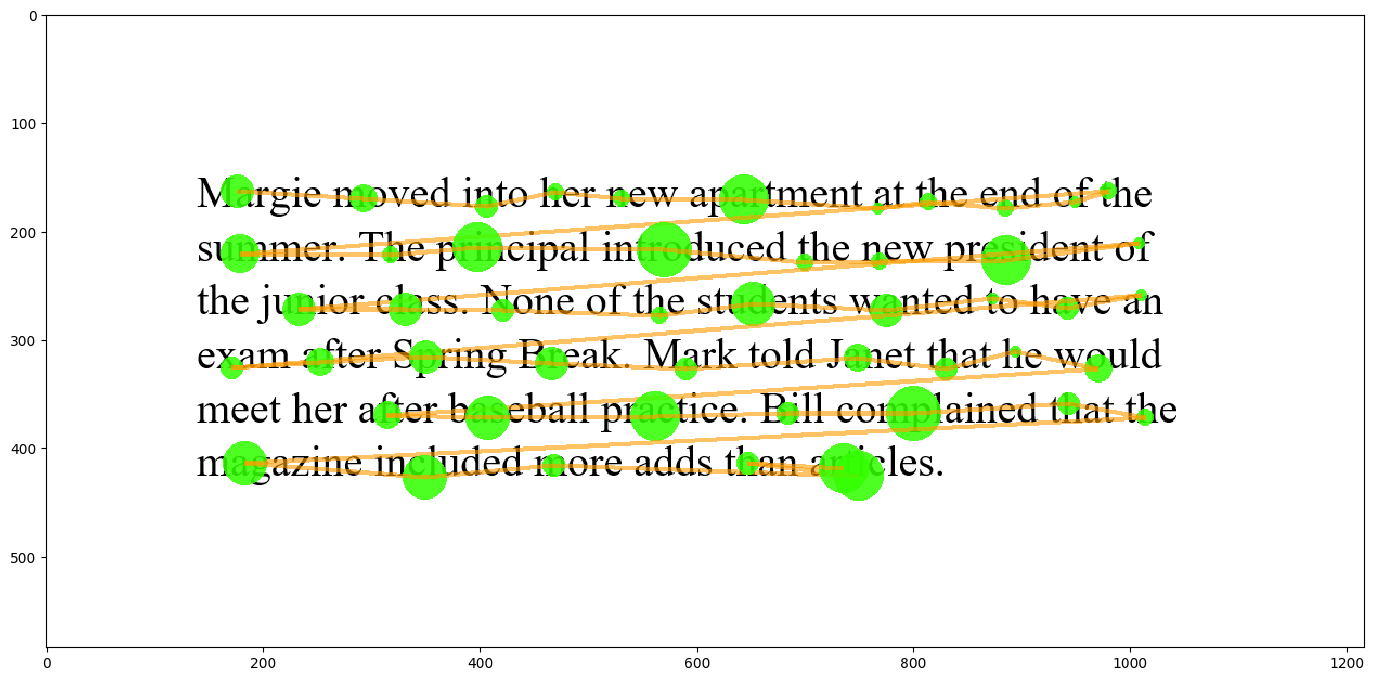

In [6]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

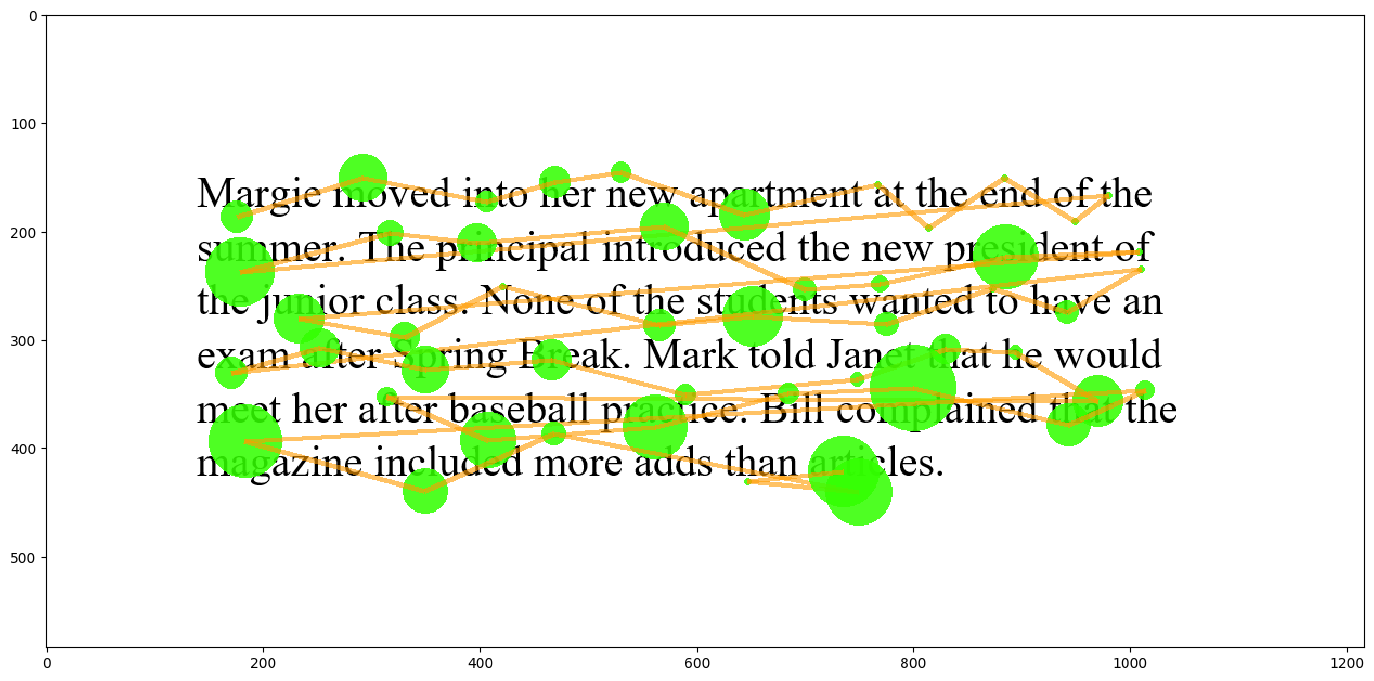

In [7]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

1.0


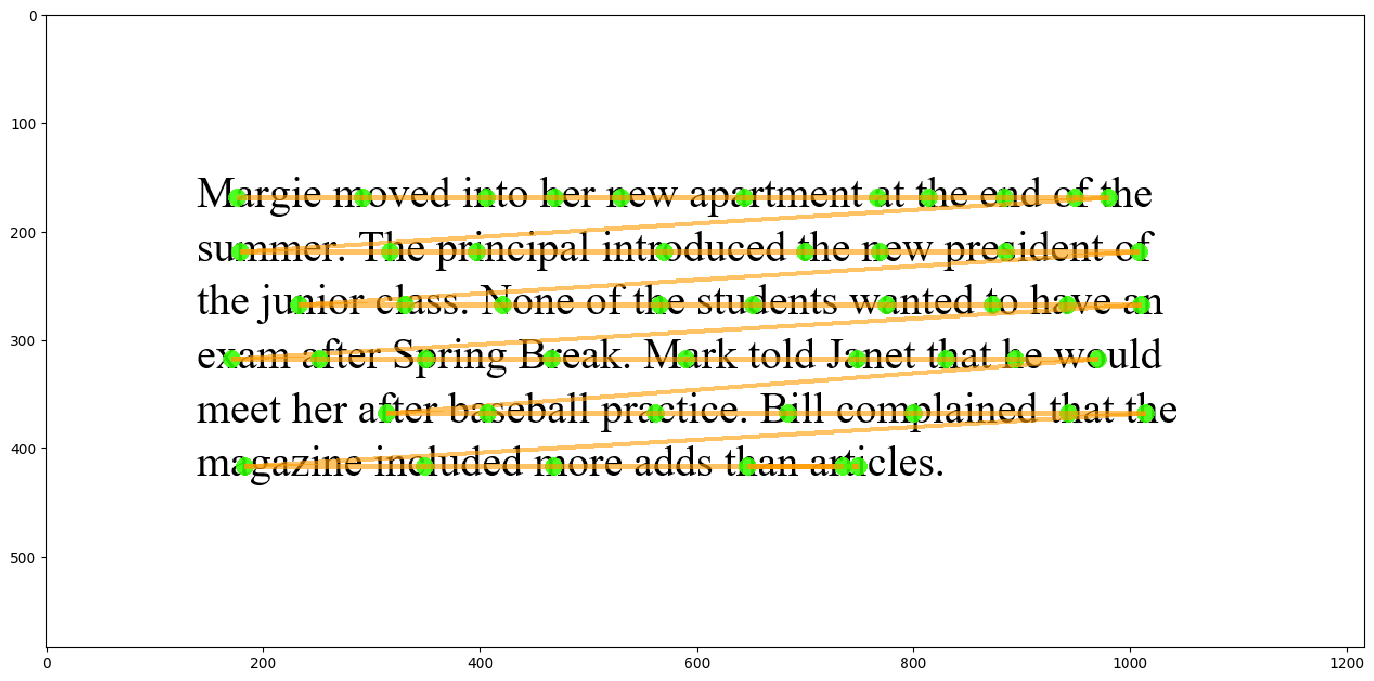

In [8]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

  0%|          | 0/1 [00:00<?, ?it/s]

robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9


100%|██████████| 1/1 [00:09<00:00,  9.40s/it]

robot: 0     error probability: 10


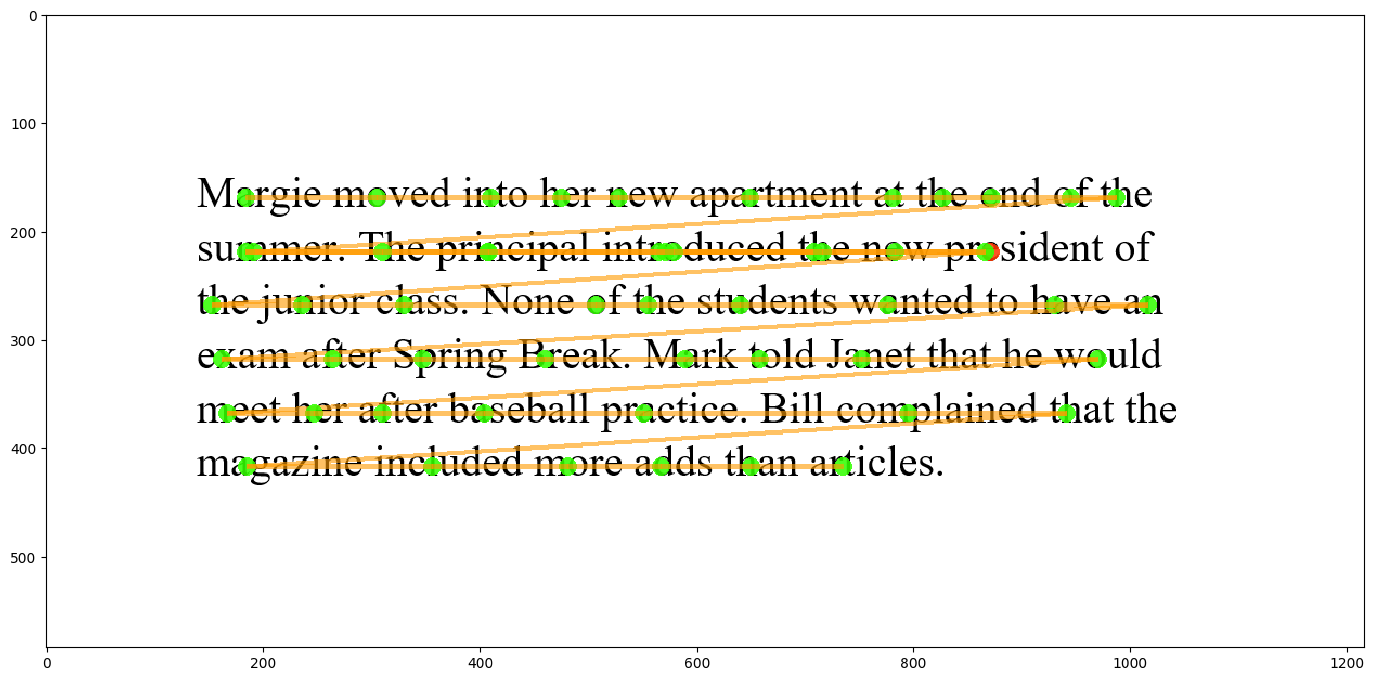

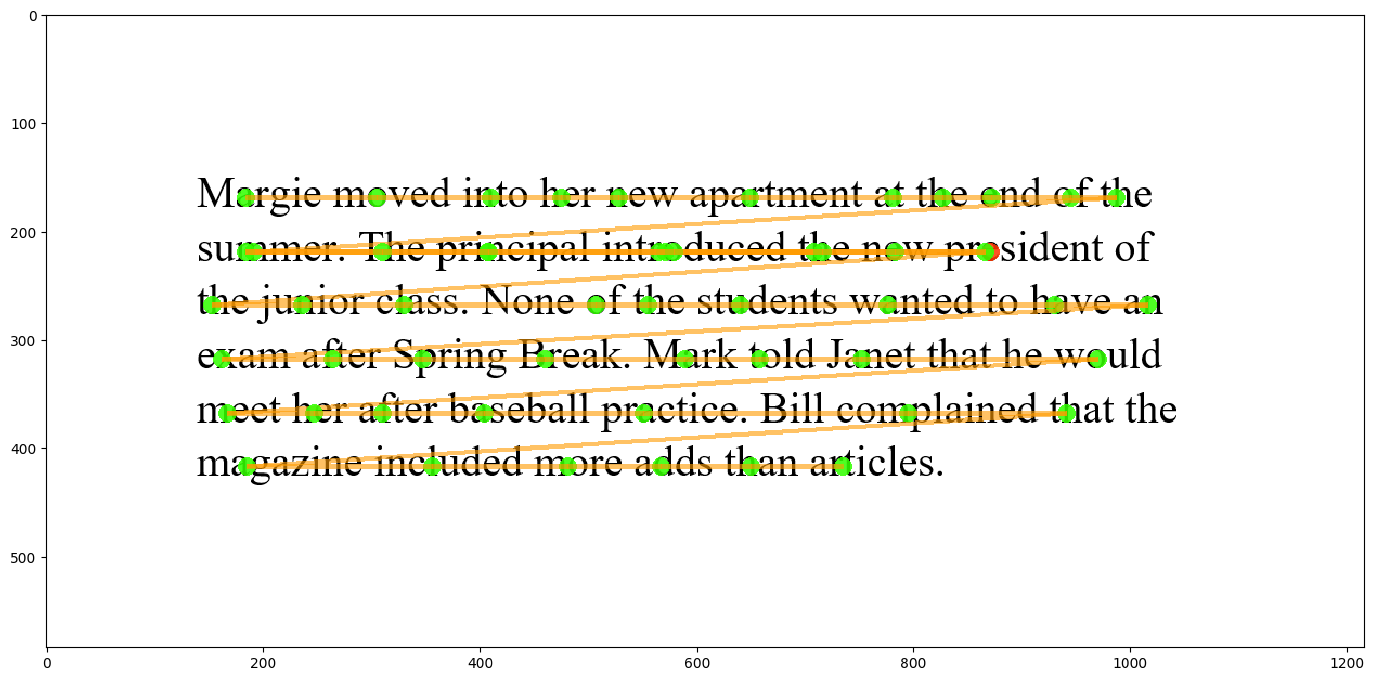

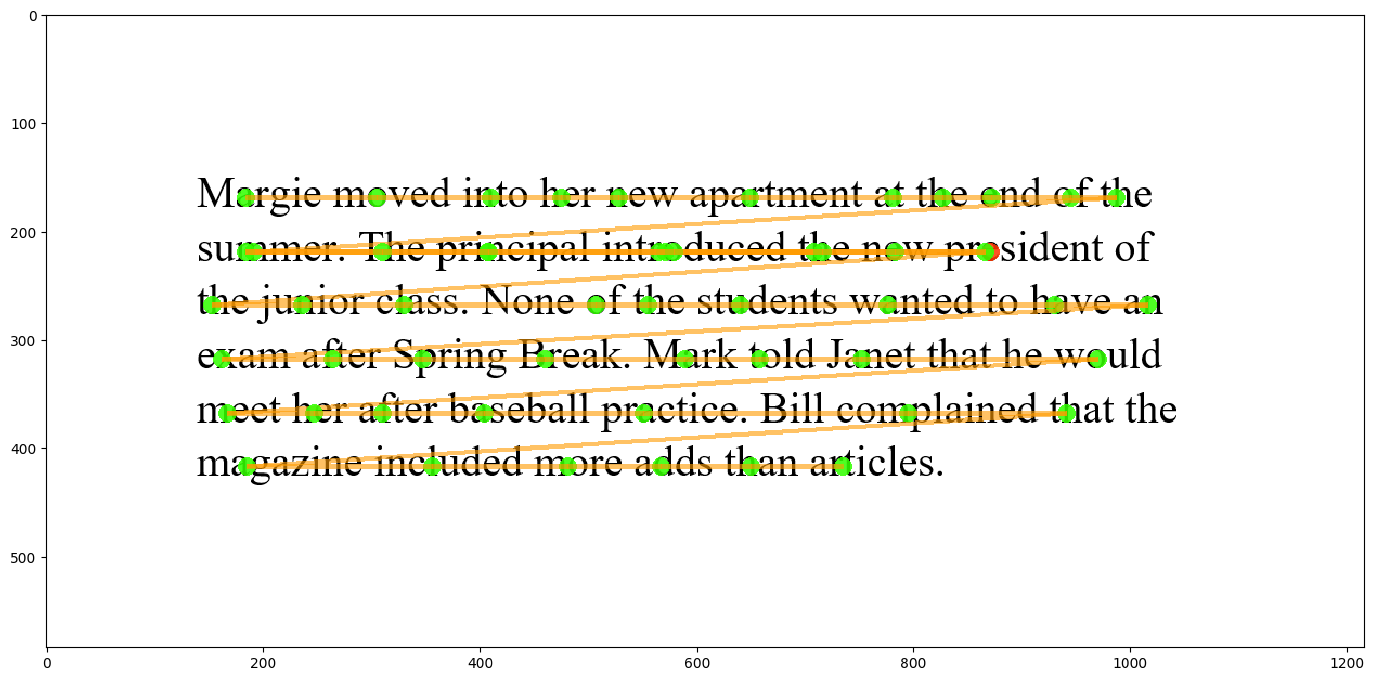

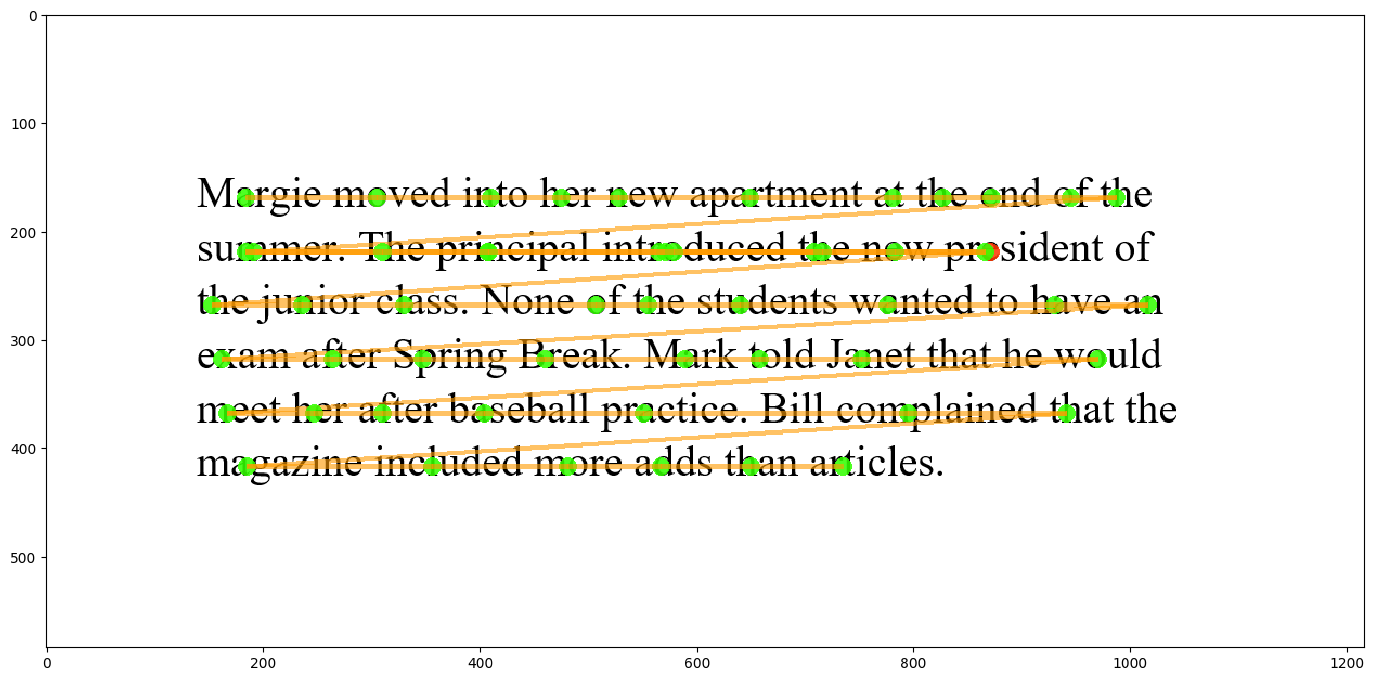

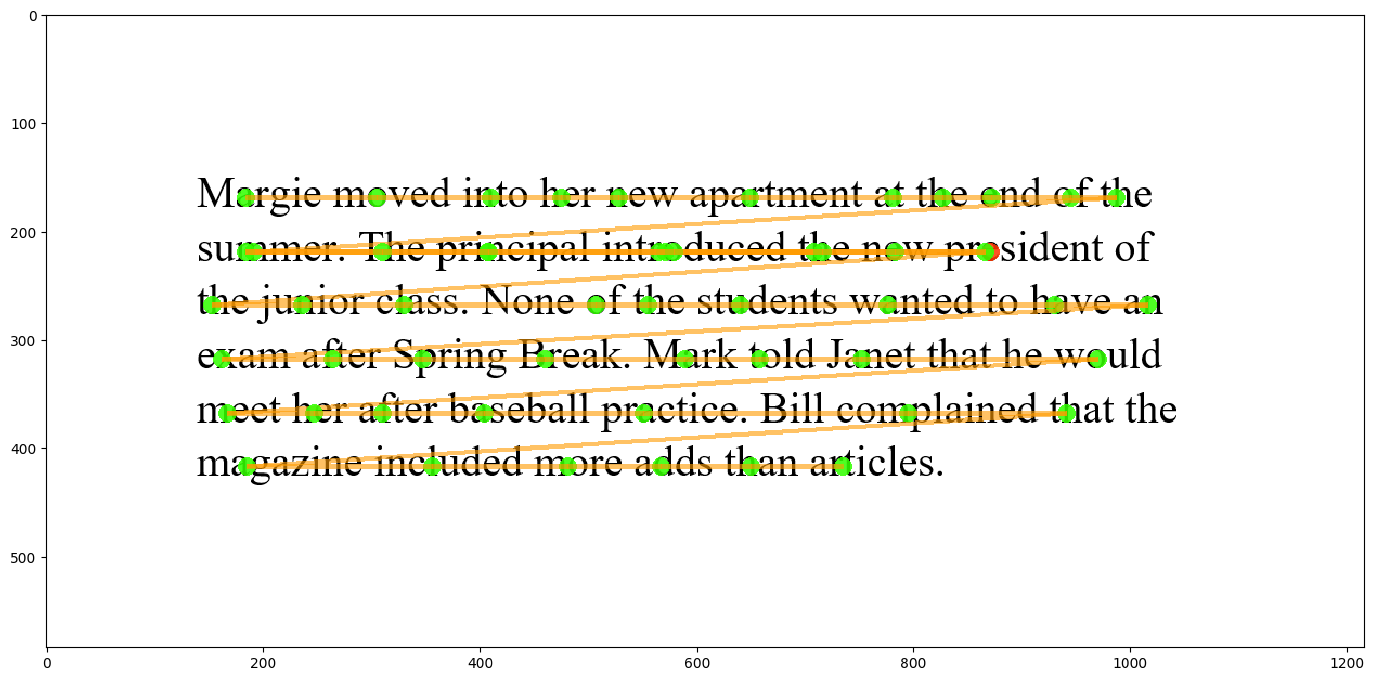

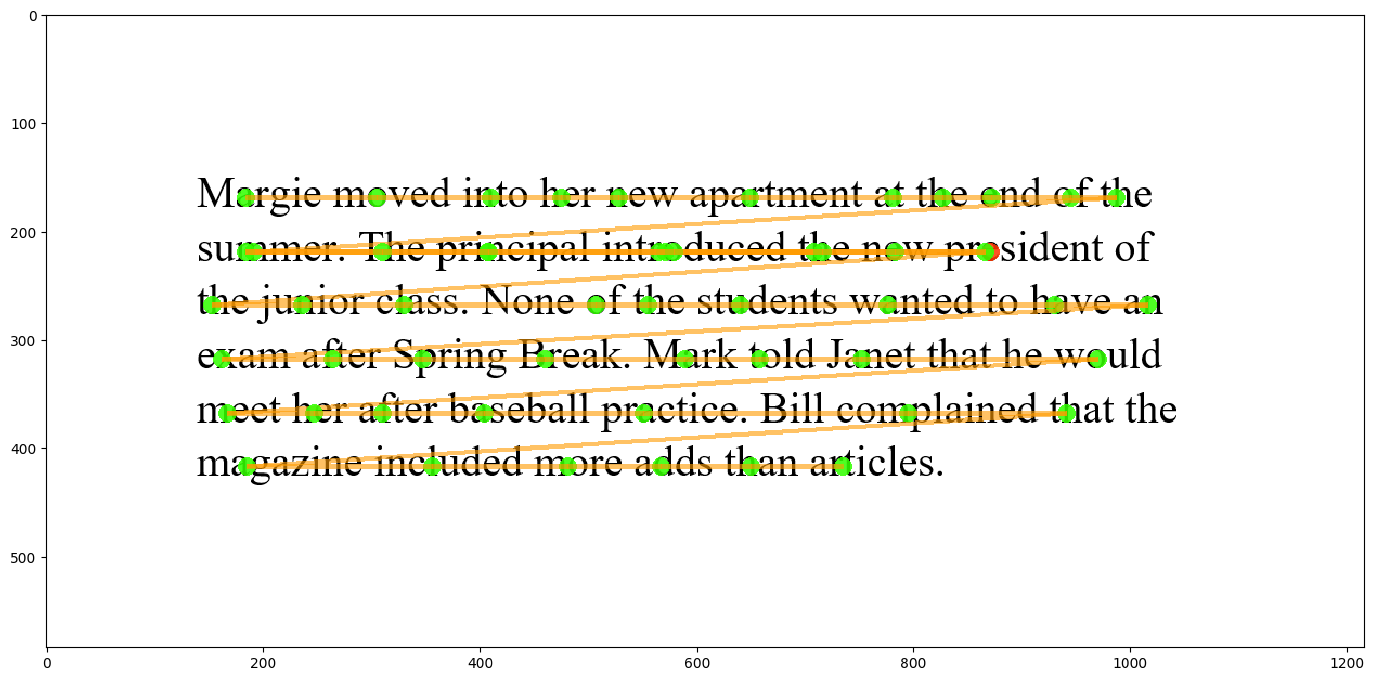

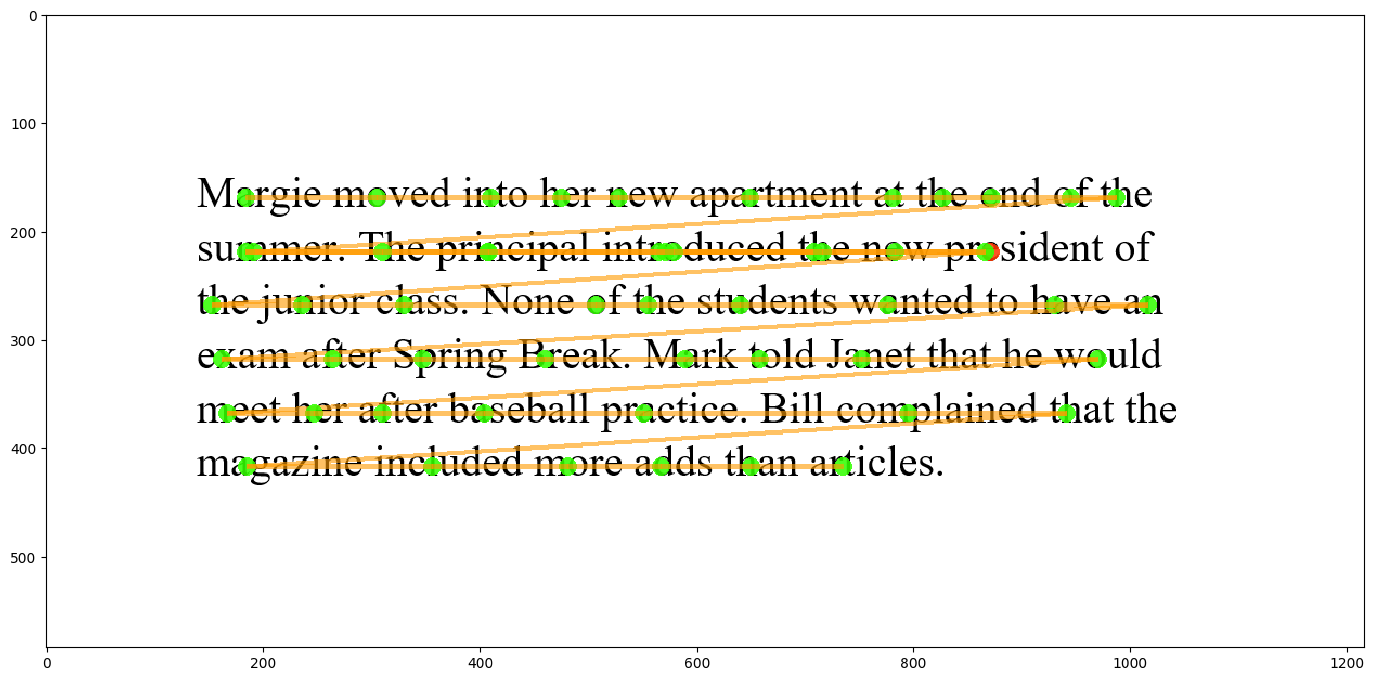

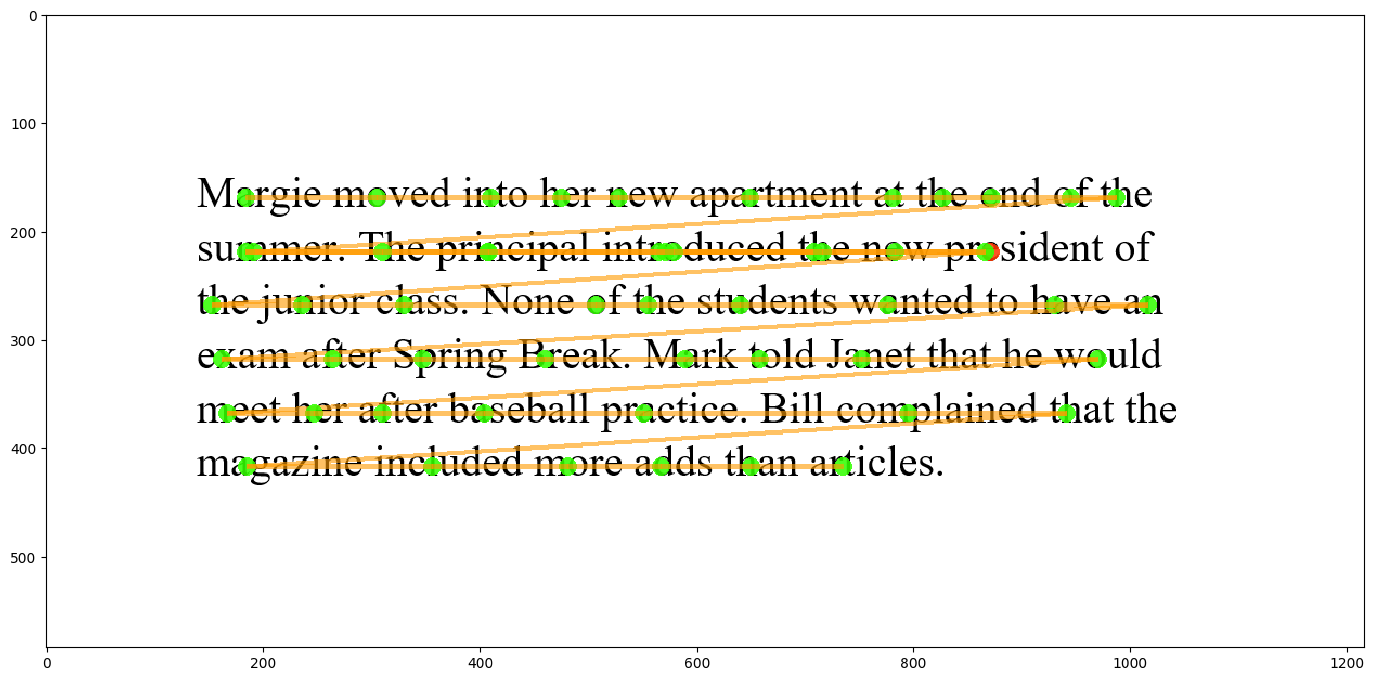

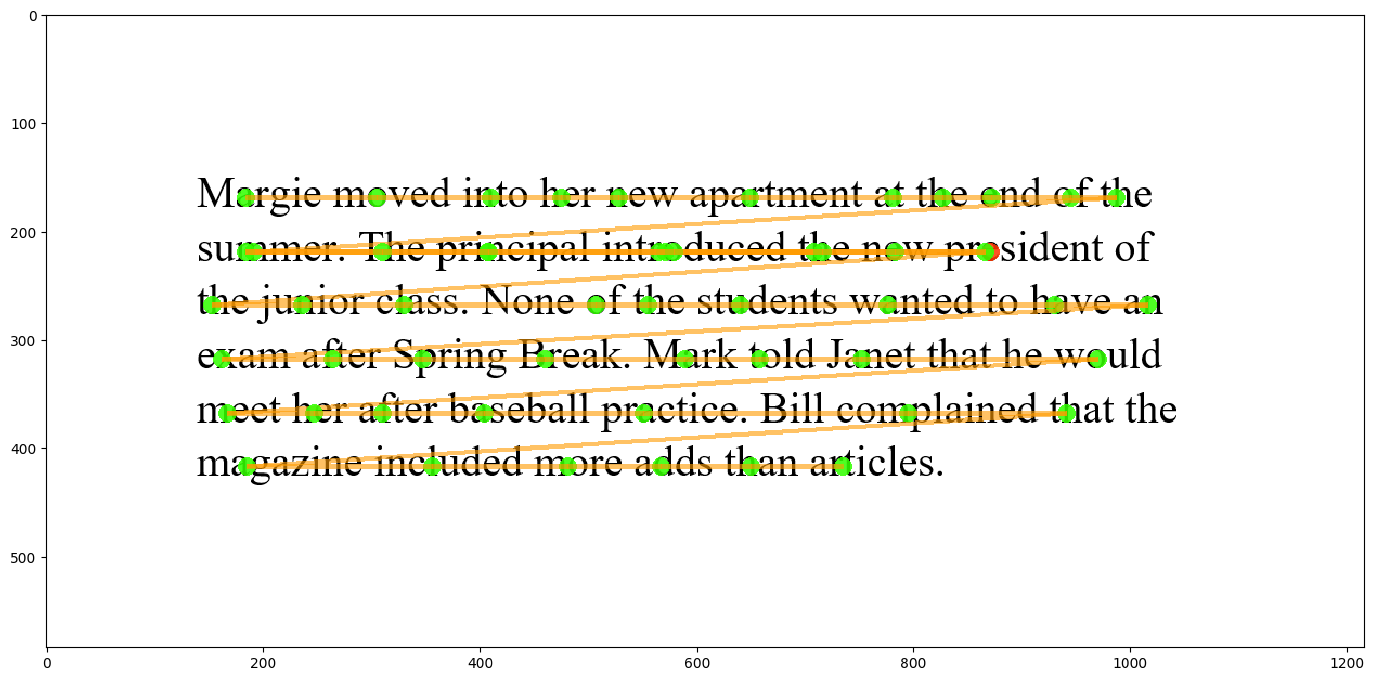

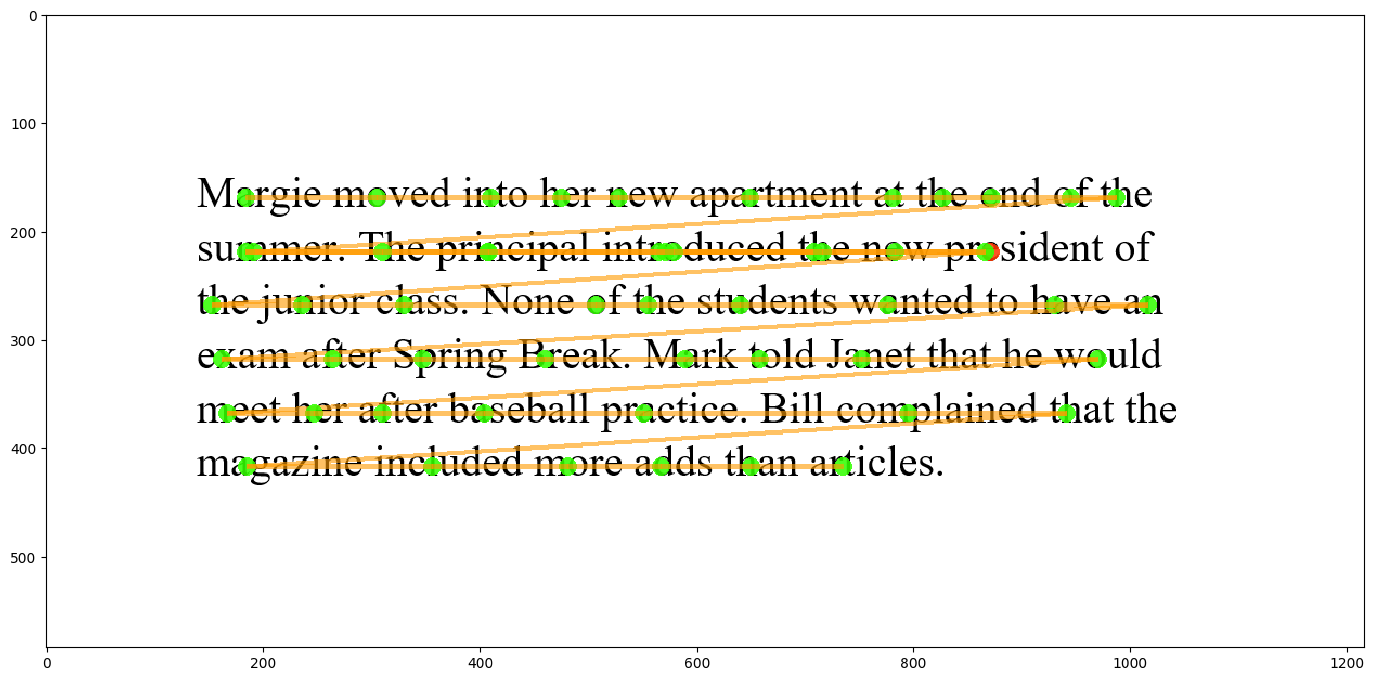

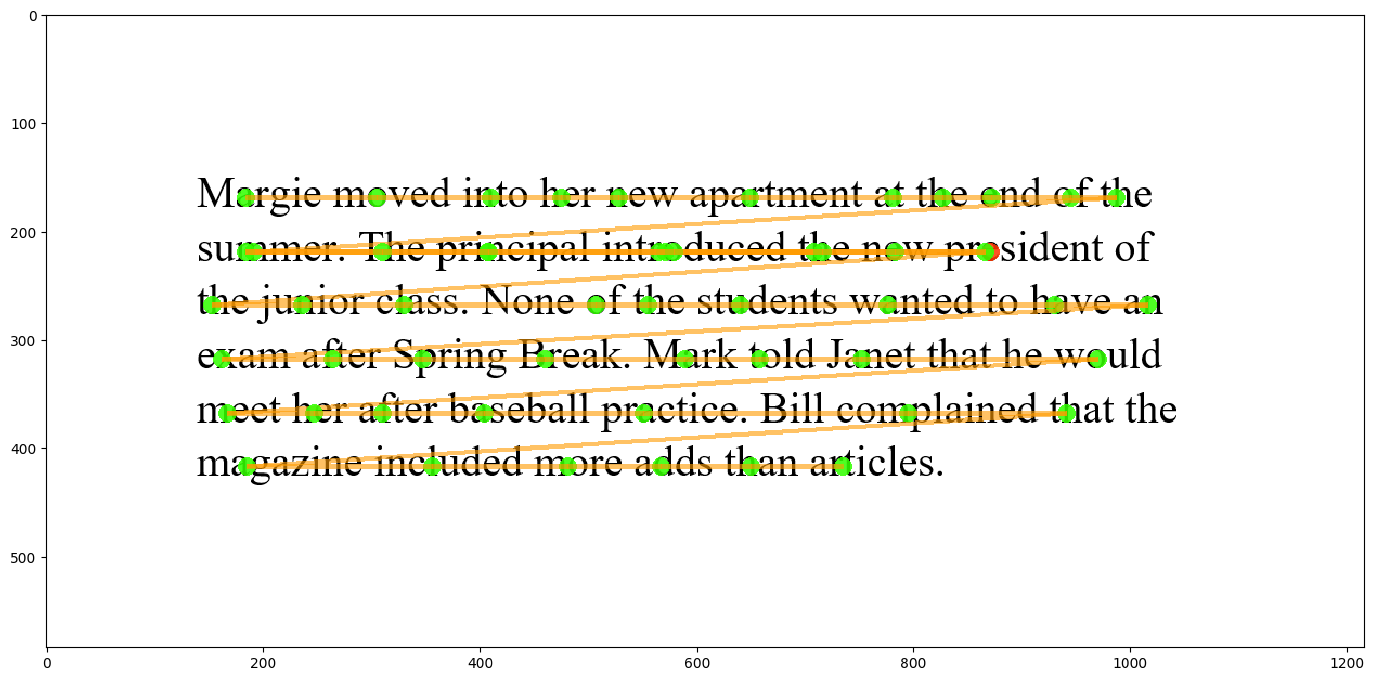

In [25]:
import my_refactor as r

attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(1)):#1 is for one robot
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_noise(error_probability/10, 30, error_probability/10, data['robot' + str(robot_index)].copy())

        # attach correction
        percentage = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)

        if percentage < 1:
            correction.draw_correction('synthetic_text.png', warp_correction, match_list)
            print("robot:", robot_index, "    error probability:", error_probability)


In [18]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [19]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)

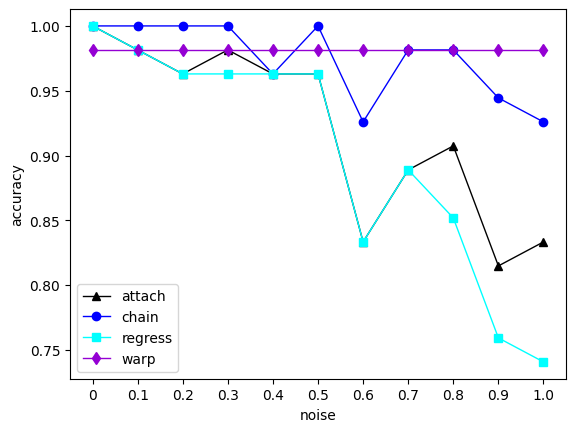

In [20]:
import matplotlib.pyplot as plt
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.legend(['attach', 'chain', 'regress', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('noise')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [21]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))

mean attach: 0.9208754208754208
mean chain: 0.9747474747474747
mean regress: 0.9006734006734006
mean warp: 0.9814814814814815


: 

: 

: 